In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/mattijnvanhoek/miniconda3/lib/python3.7/site-packages/flopy


In [2]:
workspace = r'/Users/mattijnvanhoek/modflow6/output/mf-mt-hatari'
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [3]:
# name
name = 'mf-hatari'

# exe name
exe_name = r'/Users/mattijnvanhoek/modflow6/bin/mf6'

sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name=exe_name, 
    version='mf6',
    sim_ws=workspace
)

In [4]:
# Model domain and grid definition
Lx = 310
Ly = 310
nlay = 1
nrow = 31
ncol = 31
delr = Lx / ncol
delc = Ly / nrow
top = np.ones((nrow, ncol))
botm = np.zeros((nrow, ncol))
perlen = 27.

In [5]:
tdis = flopy.mf6.ModflowTdis(
    simulation=sim, 
    time_units='DAYS', 
    pname='tdis',
    perioddata=((perlen, 1, 1.),)
)

In [6]:
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(
    simulation=sim, 
    modelname=name, 
    model_nam_file=model_nam_file
)

In [7]:
ims = flopy.mf6.ModflowIms(
    simulation=sim, 
    pname='ims', 
    complexity='SIMPLE'
)

In [8]:
idomain = np.ones((nlay, nrow, ncol), dtype=np.int32)

dis = flopy.mf6.ModflowGwfdis(
    model=gwf, 
    pname='dis', 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm, 
    idomain=idomain
)

In [9]:
strt = 15 #starting head

ic = flopy.mf6.ModflowGwfic(
    model=gwf, 
    pname='ic', 
    strt=strt
)

In [10]:
npf = flopy.mf6.ModflowGwfnpf(
    model=gwf, 
    pname='npf', 
    icelltype=0, 
    save_flows=True
)

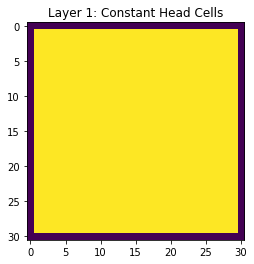

In [11]:
chd_data = []
chd = 15    
    
for c in range(1,31):
    dd = [(0, 0, c), chd]
    chd_data.append(dd)
for c in range(1,31):
    dd = [(0, c, 30), chd]
    chd_data.append(dd)
for c in range(0,30):
    dd = [(0, 30, c), chd]
    chd_data.append(dd)
for c in range(0,30):
    dd = [(0, c, 0), chd]
    chd_data.append(dd)    

chd = flopy.mf6.ModflowGwfchd(
    model=gwf, 
    pname='chd', 
    maxbound=len(chd_data), 
    stress_period_data=chd_data, 
    save_flows=True
)
ra = chd.stress_period_data.get_data(key=0)    

ibd = np.ones((nlay, nrow, ncol), dtype=np.int)
for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))
plt.show()

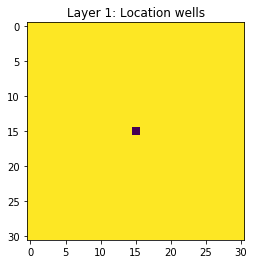

In [12]:
# build a stress_period_data template with 1 wells over 1 stress period
wel_periodrec = flopy.mf6.ModflowGwfwel.stress_period_data.empty(
    model=gwf, 
    maxbound=1, 
    boundnames=True, 
    aux_vars=None,
    stress_periods=[0]
)

wcol = 15  # x index for the well
wrow = 15  # y index for the well
wlay = 0
q = 100. # postive is injection, negative is extraction

# [idx_stress_period][idx_well] = ((wlay, wrow, wcol), q, name_well)
wel_periodrec[0][0] = ((wlay, wrow, wcol), q, 'well_1')

# build the well package
wel = flopy.mf6.ModflowGwfwel(
    model=gwf,
    pname='wel', 
    print_input=True, 
    print_flows=True,
    maxbound=1,
    stress_period_data=wel_periodrec, 
    boundnames=True, 
    save_flows=True
)

ra = wel.stress_period_data.get_data(key=0)

ibd = np.ones((nlay, nrow, ncol), dtype=np.int)
for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Location wells'.format(ilay + 1))
plt.show()

In [13]:
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
    
oc = flopy.mf6.ModflowGwfoc(
    model=gwf, 
    pname='oc', 
    saverecord=saverecord, 
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord
)

In [14]:
# Write the datasets
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf-hatari...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package wel...
    writing package oc...


In [15]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: /Users/mattijnvanhoek/modflow6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

  MODFLOW 6 compiled Jan  2 2020 21:28:58 with GFORTRAN compiler (ver. 8.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS

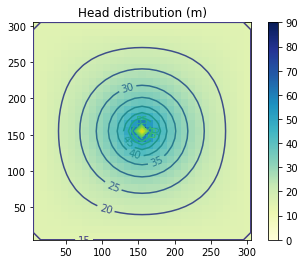

In [16]:
# plot model results
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

# create the headfile object
fname = os.path.join(workspace, headfile)
headobj = flopy.utils.binaryfile.HeadFile(fname)
head = headobj.get_data(totim=27)
times = headobj.get_times()

# Setup contour parameters
levels = np.arange(0, 90, 5)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)

# Make the plots
plt.subplot(1, 1, 1, aspect='equal')
plt.title('Head distribution (m)')
plt.imshow(head[0, :, :], extent=extent, cmap='YlGnBu', vmin=0., vmax=90.)
plt.colorbar()

contours = plt.contour(np.flipud(head[0, :, :]), levels=levels, extent=extent, zorder=10)
plt.clabel(contours, inline=1, fontsize=10, fmt='%d')

plt.show()

In [17]:
## Trial 1
# name
name_mt3d = 'mt-hatari'

# exe name
exe_name = r'/Users/mattijnvanhoek/modflow6/bin/mt3dusgs'

#MT3D-USGS
mt_model = flopy.mt3d.Mt3dms(
    modelname=name_mt3d,
    version='mt3d-usgs',
    exe_name=exe_name,
    modflowmodel=sim
)

#BTN file
icbund = idomain.copy()
icbund[0, 15, 15] = -1 #constant concentration

btn = flopy.mt3d.Mt3dBtn(
    model=mt_model, 
    sconc=0.0, 
    prsity=0.3, 
    thkmin=0.01, 
    munit='g', 
    icbund=icbund
)

Exception: BTN error. Required input is None, but no modflow model. If no modflow model is passed to Mt3dms, then values must be specified in the BTN constructor for: nlay, nrow, ncol, nper, laycon, delr, delc, htop, dz, perlen, nstp, and tsmult.

In [18]:
## Trial 2
# name
name_mt3d = 'mt-hatari'

# exe name
exe_name = r'/Users/mattijnvanhoek/modflow6/bin/mt3dusgs'

#MT3D-USGS
mt_model = flopy.mt3d.Mt3dms(
    modelname=name_mt3d,
    version='mt3d-usgs',
    exe_name=exe_name,
    modflowmodel=gwf  # <--- changed from sim into gwf
)

#BTN file
icbund = idomain.copy()
icbund[0, 15, 15] = -1 #constant concentration

btn = flopy.mt3d.Mt3dBtn(
    model=mt_model, 
    sconc=0.0, 
    prsity=0.3, 
    thkmin=0.01, 
    munit='g', 
    icbund=icbund
)

AttributeError: 'ModflowGwfdis' object has no attribute 'nper'

In [19]:
## Trial 3
tdis.nper  # time discretization package contains a nper attr

{internal}
(1)

In [20]:
# name
name_mt3d = 'mt-hatari'

# exe name
exe_name = r'/Users/mattijnvanhoek/modflow6/bin/mt3dusgs'

#MT3D-USGS
mt_model = flopy.mt3d.Mt3dms(
    modelname=name_mt3d,
    version='mt3d-usgs',
    exe_name=exe_name,
    modflowmodel=gwf  # <--- changed from sim into gwf
)

#BTN file
icbund = idomain.copy()
icbund[0, 15, 15] = -1 #constant concentration

btn = flopy.mt3d.Mt3dBtn(
    model=mt_model, 
    sconc=0.0, 
    prsity=0.3, 
    thkmin=0.01, 
    munit='g', 
    icbund=icbund,
    nper=tdis.nper  # <--- from the time discretization package
)

AttributeError: 'MFArray' object has no attribute 'get_value'

In [21]:
gwf.dis.delr.get_value()

AttributeError: 'MFArray' object has no attribute 'get_value'

In [22]:
gwf.dis.delr.get_data()

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10.])

In [ ]:
# # advaction package
# adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75)
# # dispersion package
# dsp = flopy.mt3d.Mt3dDsp(mt, al=10.0, trpt=0.1, trpv=0.1, dmcoef=1e-09)

# # source/sink package
# ssm_data = {}
# itype = flopy.mt3d.Mt3dSsm.itype_dict()
# ssm_data[0] = [(0, wrow, wcol, 10.0, itype['WEL'])]

# ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

# # matrix solver package
# gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)

# # write mt3dms input
# mt.write_input()
# # run mt3dms
# mt.run_model()

# # post-processing and plotting
# # plot flow
# import matplotlib.pyplot as plt
# import flopy.utils.binaryfile as bf
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')

# wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) # origin at low upper..
# hds = bf.HeadFile(modelname+'.hds')
# times = hds.get_times() # simulation time, steady state
# head = hds.get_data(totim=times[-1])

# cbb = bf.CellBudgetFile(modelname+'.cbc') # read budget file
# frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
# fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

# # create flopy plot object, plot grid and contour
# modelmap = flopy.plot.ModelMap(model=mf, layer=0)
# lc = modelmap.plot_grid() # grid
# cs = modelmap.contour_array(head, levels=np.linspace(head.min(), head.max(), 21)) # head contour
# plt.clabel(cs, fontsize=20, fmt='%1.1f', zorder=1) # contour label
# quiver = modelmap.plot_discharge(frf, fff, head=head) # quiver
# plt.plot(wpt[0],wpt[1],'ro') # well location
# plt.show()

# # plot conc
# ucnobj = bf.UcnFile('MT3D001.UCN')
# #print(ucnobj.list_records()) # get values

# times = ucnobj.get_times() # simulation time
# times1 = times[round(len(times)/4.)] # 1/4 simulation time
# times2 = times[round(len(times)/2.)] # 1/2 simulation time
# times3 = times[-1] # the last simulation time

# conc1 = ucnobj.get_data(totim=times1)
# conc2 = ucnobj.get_data(totim=times2)
# conc3 = ucnobj.get_data(totim=times3)


# # conc 100 day
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# modelmap = flopy.plot.ModelMap(model=mf, layer=0)
# lc = modelmap.plot_grid() # grid
# cs = modelmap.plot_array(conc1) # head contour
# plt.colorbar(cs) # colrobar
# plt.plot(wpt[0],wpt[1],'ro')
# plt.title('C  %g day' % times1)
# plt.show()

# # conc in 500 days
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# modelmap = flopy.plot.ModelMap(model=mf, layer=0)
# lc = modelmap.plot_grid() # grid
# cs = modelmap.plot_array(conc2) # head contour
# plt.colorbar(cs) # colrobar
# plt.plot(wpt[0],wpt[1],'ro')
# plt.title('C  %g day' % times2)
# plt.show()


# # conc in 1000 days
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')
# modelmap = flopy.plot.ModelMap(model=mf, layer=0)
# lc = modelmap.plot_grid() # grid
# cs = modelmap.plot_array(conc3) # head contour
# plt.colorbar(cs) # colrobar
# plt.plot(wpt[0],wpt[1],'ro')
# plt.title('C  %g day' % times3)
# plt.show()

